# Transmission pairs permutation test

June 18, 2020 

We would like to determine whether samples collected in the same geographic area share more variants than expected by chance alone. I am imagining the following permutation test: 

1. Select 2 samples at random. Compute the proportion of total variants between them that are shared. Do this a bunch of times. Make a distribution of results. 
2. Select 2 samples from the same geographic area. Repeat. 
3. Finally, compute the fraction of shared variants between transmission pairs. Plot this as a dotted line on this distribution. This can give you a p-value. 

In [1]:
import imp
import importlib, json
import glob
import re,copy,json
import Bio.Phylo
import requests
import pandas as pd 
import numpy as np

import copy
from scipy.special import binom
import datetime as dt

from datetime import date
from datetime import datetime

import rpy2
%load_ext rpy2.ipython

## Read in household dataset metadata

Read in metadata file containing the date of symptom onset

In [59]:
def read_in_diff_symptom_onsets(diff_onsets_file):
    onsets_dict = {}
    
    with open(diff_onsets_file, "r") as infile: 
        for line in infile: 
            tip1 = line.split("\t")[0]
            tip2 = line.split("\t")[1]
            tubes = line.split("\t")[2]
            tips = str(sorted([tip1,tip2]))
            diff_symptom_onsets = line.split("\t")[3].strip()

            onsets_dict[tubes] = {"sample1":tip1, "sample2":tip2, "onset_dates_diff":diff_symptom_onsets}
        
    return(onsets_dict)

In [3]:
def format_strain_name(strain_name):
    strain_name = strain_name.replace("hCoV-19/","")
    if "USA/" not in strain_name:
        strain_name = "USA/" + strain_name
    if "/2020" not in strain_name: 
        strain_name = strain_name + "/2020"
        
    return(strain_name)

In [4]:
def format_date(input_date):
    
    if "VALUE" in input_date:
        full_date = "unknown"
    
    else:
        input_date = input_date.split(" ")[0]

        month = input_date.split("/")[0]
        day = input_date.split("/")[1]
        year = "20"+input_date.split("/")[2]

        if len(month) == 1:
            month = "0" + month
        if len(day) == 1:
            day = "0" + day

        full_date = year + "-" + month + "-" + day
    
    return(full_date)

In [5]:
def read_metadata(metadata_file_path):
    
    metadata_dict = {}
    
    with open(metadata_file_path) as infile: 
        for line in infile:
            if "Household" not in line and line.replace("\t","") != "\n":  # skip the first line
                household = line.split("\t")[0]
                strain_name = line.split("\t")[7]
                date_symptom_onset = line.split("\t")[15]
                
                formatted_strain_name = format_strain_name(strain_name)
                formatted_date_onset = format_date(date_symptom_onset)

                metadata_dict[formatted_strain_name] = {"date_symptom_onset":formatted_date_onset}
            
    return(metadata_dict)

## Code up the permutation test

In [6]:
def pick_2_random_numbers(list_to_sample_from):
    
    import random
    selections = random.sample(list_to_sample_from, 2)
    return(selections[0],selections[1])

In [7]:
def compute_shared_variant_proportion(sample1,sample2,df,variant_column):
    shared_variants = 0
    
    s1_df = df[df['strain_name'] == sample1]
    variants_in_s1 = set(s1_df[variant_column].tolist())
    
    s2_df = df[df['strain_name'] == sample2]
    variants_in_s2 = set(s2_df[variant_column].tolist())
    
    total_variants = len(variants_in_s1) + len(variants_in_s2)
    if len(variants_in_s1) == 0 or len(variants_in_s2) == 0:
        proportion_shared = 0
        number_shared = 0
    
    else:
        for v in variants_in_s1:
            if v in variants_in_s2:
                shared_variants += 2
            
        proportion_shared = float(shared_variants/total_variants)
        number_shared = shared_variants
            
    return(proportion_shared, number_shared)

In [8]:
def run_permutation_test(iterations, df_to_run,variant_column):
    
    # run a bunch of times
    output_prop_list = []
    output_number_list = []

    for i in range(iterations):
        # query all strains
        list_to_query = set(df_to_run['strain_name'].tolist())
        s1,s2 = pick_2_random_numbers(list_to_query)
    
        # with those random pairs of samples, compute the proportion of snvs that are shared
        proportion_variants_shared,number_variants_shared = compute_shared_variant_proportion(s1,s2,df_to_run,variant_column)
        output_prop_list.append(proportion_variants_shared)
        output_number_list.append(number_variants_shared)
        
    # return dataframes
    output_prop_df = pd.DataFrame(output_prop_list)
    output_prop_df.columns = ['proportion_shared']
    
    output_number_df = pd.DataFrame(output_number_list)
    output_number_df.columns = ['number_shared']

    return(output_prop_list, output_number_list, output_prop_df, output_number_df)

In [9]:
def run_permutation_test_no_household_pairs(iterations, df_to_run,household_groups):
    
    # first, generate all combinations of household pairs
    all_pairs = []
    for household in household_groups:
        total_pairs = generate_all_combinations_pairs(household)
        for pair in total_pairs:
            all_pairs.append(pair)
    
    # run a bunch of times
    output_prop_list = []
    output_number_list = []

    for i in range(iterations):
        # query all strains
        list_to_query = set(df_to_run['strain_name'].tolist())
        s1,s2 = pick_2_random_numbers(list_to_query)
        
        if [s1,s2] not in all_pairs:
        
            # with those random pairs of samples, compute the proportion of snvs that are shared
            proportion_variants_shared,number_variants_shared = compute_shared_variant_proportion(s1,s2,df_to_run)
            output_prop_list.append(proportion_variants_shared)
            output_number_list.append(number_variants_shared)
        else:
            pass
        
    # return dataframes
    output_prop_df = pd.DataFrame(output_prop_list)
    output_prop_df.columns = ['proportion_shared']
    
    output_number_df = pd.DataFrame(output_number_list)
    output_number_df.columns = ['number_shared']

    return(output_prop_list, output_number_list, output_prop_df, output_number_df)

## Compute p-values for transmission pairs 

For each transmission pair, compute the proportion of variants shared, and compare to the fraction of random pairs that have at least that much shared variation

In [10]:
import itertools

def generate_all_combinations_pairs(list_of_elements):
    all_pairs = []
    for pair in itertools.combinations(list_of_elements, 2):
        all_pairs.append(list(pair))
    return(all_pairs)

In [11]:
def subtract_dates(date1,date2):
    d1 = datetime.strptime(date1,"%Y-%m-%d")
    d2 = datetime.strptime(date2,"%Y-%m-%d")
    delta = d1 - d2
    
    return(str(abs(delta.days)))

In [12]:
def compute_difference_onset_dates(sample1,sample2, metadata_dict):
        
    if sample1 in metadata_dict:
        date1 = metadata_dict[sample1]['date_symptom_onset']
    else:
        date1 = "unknown"
    if sample2 in metadata_dict:
        date2 = metadata_dict[sample2]['date_symptom_onset']
    else:
        date2 = "unknown"
    
    if date1 != "unknown" and date2 != "unknown":  
        difference = subtract_dates(date1,date2)
    else:
        difference = ""
    
    return(difference)

In [92]:
def compute_p_values_for_transmission_pairs(metadata_dict, household_groups, pairs_to_exclude,df_with_variants, list_of_permuted_shared_proportions, variant_column):
    
    shared_fractions = []
    diff_onset_dates = []
    p_values = []
    tip1 = []
    tip2 = []

    for household in household_groups:
        total_pairs = generate_all_combinations_pairs(household)
        for pair in total_pairs:
            if pair not in pairs_to_exclude:
                sample1 = pair[0]
                sample2 = pair[1]
                
                date_diff = compute_difference_onset_dates(sample1,sample2,metadata_dict)
                proportion_variants_shared,number_variants_shared = compute_shared_variant_proportion(sample1,sample2,df_with_variants, variant_column)

                # now calculate the number of random pairs with at least as much shared variation as the transmission pair
                fraction_more_extreme = compute_p_value(proportion_variants_shared, list_of_permuted_shared_proportions)

                shared_fractions.append(proportion_variants_shared)
                p_values.append(fraction_more_extreme)
                tip1.append(sample1)
                tip2.append(sample2)
                #diff_onset_dates.append(date_diff)
        
    return(shared_fractions,p_values, tip1,tip2)

In [81]:
def compute_p_value(proportion_variants_shared, list_of_permuted_shared_proportions):
    count = 0
    for p in list_of_permuted_shared_proportions:
        if p >= proportion_variants_shared:
            count += 1
            
    fraction_more_extreme = count/len(list_of_permuted_shared_proportions)
    return(fraction_more_extreme)

In [91]:
def generate_df2(shared_fractions,p_values,tip1,tip2):
    y_limit = 8500
    y_limits = [y_limit] * len(shared_fractions)
    
    pairs = []
    for i in range(len(shared_fractions)):
        pair_number = str(i + 1)
        pairs.append(pair_number)
    
    shared_fractions_dict = {"pair":pairs,"sample1":tip1, "sample2":tip2,
                         "fraction_shared":shared_fractions,
                        "y":y_limits,
                        "p_value":p_values}
    df2 = pd.DataFrame.from_dict(shared_fractions_dict)
    df2['color'] = np.where(df2['p_value'] < 0.05, "significant","not")
    
    return(df2)

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled).

In [84]:
# define which column we want to use to look at variants. Use 'nuc_muts' to characterize variants relative to the 
# Wuhan 1 reference, or 'minor_nuc_muts' to do a consensus-agnostic comparison
variant_column = 'minor_nuc_muts'
frequency_column = 'minor_frequency'

In [85]:
# read in the current date 
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))

In [86]:
variant_percent = "0.03"

In [87]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [21]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "../data/consensus-sequences-2021-01-25.fasta"
clades_file = "../data/clades-file-2020-08-28.txt"
vcf_directory = "../data/vcfs-all/"

# N transcript was a control; I am going to exclude tube 127, USA/WI-UW-118/2020
# which has >50 indels and >50 SNVs. It has a pretty high Ct as well, so I think these are probably errors 
# as it is a very clear outlier
# remove 302, 303, 304, 302, 735, and 736 because these are time-series! 
samples_to_ignore = ["N_transcript","127","302","303","304","735","736"]

# set the length of homopolymers that you want to use
homopolymer_length = 3

# set the variant percent that you want to use 
variant_percent = "0.03"

snvs_only, all_intersection_variants,metadata_dict, strain_names_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file, homopolymer_length)

In [22]:
print(len(snvs_only))

1173


In [23]:
"""gather twist sites"""
twist_sites = snvs_only[snvs_only['sampleid'] == "twist_rna"]['POS_x'].tolist()

"""remove all rows containing variants at twist sites"""
snvs_only = snvs_only[~snvs_only['POS_x'].isin(twist_sites)]

In [24]:
print(len(snvs_only))

1166


In [25]:
"""subset data to include only SNVs and indels >X% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] >= float(variant_percent)]

"""subset data to include only SNVs and indels <50% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] <= float(0.5)]

In [26]:
snvs_only.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,gene,nt_change,aa_change,...,nt_ref,nt_mut,nuc_muts,minor_frequency,consensus_base,minor_base,consensus_aa,minor_aa,minor_nuc_muts,minor_aa_muts
0,0,orf1ab_C>T_Ser2839Ser_synonymous,8782.0,0.9376,0.8802,0.90890,53,orf1ab,C>T,Ser2839Ser,...,C,T,C8782T,0.09110,T,C,Ser,Ser,T8782C,orf1ab_Ser2839Ser
1,1,orf1ab_G>A_Val5373Ile_missense,16381.0,0.9064,0.9449,0.92565,53,orf1ab,G>A,Val5373Ile,...,G,A,G16381A,0.07435,A,G,Ile,Val,A16381G,orf1ab_Ile5373Val
2,2,orf1ab_T>C_Thr5871Thr_synonymous,17877.0,0.9543,0.9387,0.94650,53,orf1ab,T>C,Thr5871Thr,...,T,C,T17877C,0.05350,C,T,Thr,Thr,C17877T,orf1ab_Thr5871Thr
3,3,orf1ab_C>T_Phe6684Phe_synonymous,20316.0,0.9047,0.9040,0.90435,53,orf1ab,C>T,Phe6684Phe,...,C,T,C20316T,0.09565,T,C,Phe,Phe,T20316C,orf1ab_Phe6684Phe
4,4,ORF3a_G>T_Pro36Pro_synonymous,25500.0,0.9523,0.9624,0.95735,53,ORF3a,G>T,Pro36Pro,...,G,T,G25500T,0.04265,T,G,Pro,Pro,T25500G,ORF3a_Pro36Pro


In [27]:
snvs_to_query = set(snvs_only[variant_column])
print(len(snvs_to_query))

185


In [28]:
# print(len(snvs_only))
# snvs_only = snvs_only[snvs_only['POS_x'] != 15168.0]
# print(len(snvs_only))


## Run permutation test

In [88]:
# path_to_households_metadata_file = "/Users/lmoncla/src/ncov-WI-within-host/data/WI-household-transmission-pairs-from-2020-11-23/household-data-metadata-2020-11-23.txt"
# metadata_dict_households = read_metadata(path_to_households_metadata_file)


In [89]:
# make a combined dataframe with indels and snvs
s = snvs_only[["strain_name",variant_column,frequency_column,"sampleid","location"]]

In [93]:
"""this is a complete set of all samples that are part of a household group, organized by household"""
household_groups = [#["USA/WI-UW-27/2020","USA/WI-UW-85/2020"],  # UW-27 is tube 3, which had a tube switch
                      #["USA/WI-UW-40/2020","USA/WI-UW-97/2020"],  # UW-40 is tube 19, and it only has 1 replicate
                      ["USA/WI-UW-41/2020","USA/WI-UW-48/2020"],
                      ["USA/WI-UW-65/2020","USA/WI-UW-32/2020"],
                      ["USA/WI-UW-69/2020","USA/WI-UW-61/2020"],
                      ["USA/WI-UW-70/2020","USA/WI-UW-67/2020"],
                      ["USA/WI-UW-74/2020","USA/WI-UW-29/2020"],
                      ["USA/WI-UW-119/2020","USA/WI-UW-120/2020"],  # 119 is missing a consensus genome
                      #["USA/WI-UW-124/2020","USA/WI-UW-351/2020"],  # 351 has only 1 replicate
                      ["USA/WI-UW-158/2020","USA/WI-UW-160/2020"],
                      #["USA/WI-UW-264/2020","USA/WI-UW-356/2020"],  # 356 is tube 321, only has 1 replicate
                      ["USA/WI-UW-333/2020","USA/WI-UW-334/2020"],
                      ["USA/WI-UW-476/2020","USA/WI-UW-438/2020","USA/WI-UW-432/2020"],
                      ["USA/WI-UW-544/2020","USA/WI-UW-551/2020","USA/WI-UW-575/2020"],
                      ["USA/WI-UW-546/2020","USA/WI-UW-586/2020","USA/WI-UW-443/2020"],
                      ["USA/WI-UW-577/2020","USA/WI-UW-536/2020"],
                      ["USA/WI-UW-598/2020","USA/WI-UW-602/2020"], #"USA/WI-UW-689/2020", # UW-689 is tube 1049 and only has 1 replicate
                      ["USA/WI-UW-601/2020","USA/WI-UW-780/2020"],
                      ["USA/WI-UW-756/2020","USA/WI-UW-893/2020"],
                      ["USA/WI-UW-784/2020","USA/WI-UW-798/2020"],
                      #["USA/WI-UW-747/2020","USA/WI-UW-697/2020"], # removed because low coverage
                      ["USA/WI-UW-897/2020","USA/WI-UW-906/2020"],
                      ["USA/WI-UW-874/2020","USA/WI-UW-986/2020","USA/WI-UW-997/2020","USA/WI-UW-991/2020"],
                      ["USA/WI-UW-895/2020","USA/WI-UW-876/2020","USA/WI-UW-863/2020"]]  # uw-931, tube 1414 only has 1 replicate
                      #["USA/WI-UW-927/2020","USA/WI-UW-861/2020"]]  # 861, tube 1293 has only 1 replicate


"""these are all pairs for which the 2 consensus genomes are separated by >2 mutations"""
# pairs_to_exclude = []
pairs_to_exclude = [['USA/WI-UW-476/2020', 'USA/WI-UW-438/2020'], ['USA/WI-UW-476/2020', 'USA/WI-UW-432/2020'], 
                    ['USA/WI-UW-784/2020', 'USA/WI-UW-722/2020'], ['USA/WI-UW-784/2020', 'USA/WI-UW-749/2020'], 
                    ['USA/WI-UW-784/2020', 'USA/WI-UW-694/2020'], ['USA/WI-UW-784/2020', 'USA/WI-UW-721/2020'], 
                    ['USA/WI-UW-784/2020', 'USA/WI-UW-798/2020'], ['USA/WI-UW-855/2020', 'USA/WI-UW-897/2020'], 
                    ['USA/WI-UW-897/2020', 'USA/WI-UW-916/2020'], ['USA/WI-UW-897/2020', 'USA/WI-UW-906/2020']]

In [94]:
n_iterations = 10000
df_to_run = s

In [106]:
# run it for all pairs
proportions, number, proportions_df, number_df = run_permutation_test(n_iterations, df_to_run, variant_column)

shared_fractions_trans_pairs,p_values_random_pairs,tip1,tip2 = compute_p_values_for_transmission_pairs(metadata_dict_households,household_groups,pairs_to_exclude, df_to_run, proportions, variant_column)
percentile_random_pairs = np.percentile(proportions_df['proportion_shared'], 95)
df2_random = generate_df2(shared_fractions_trans_pairs,p_values_random_pairs,tip1,tip2)

In [107]:
# run it for all pairs, but excluding household pairs in the random pairs df
# proportions, number, proportions_df, number_df = run_permutation_test_no_household_pairs(n_iterations, df_to_run,household_groups)

# shared_fractions_trans_pairs,p_values_random_pairs,tip1,tip2,diff_onset_dates = compute_p_values_for_transmission_pairs(metadata_dict,household_groups,pairs_to_exclude, df_to_run, proportions)
# percentile_random_pairs = np.percentile(proportions_df['proportion_shared'], 95)
# df2_random = generate_df2(shared_fractions_trans_pairs,p_values_random_pairs,tip1,tip2,diff_onset_dates)

# Plot!

In [108]:
random_pair_color = "#C4C4C5"
sig_color =  "#2664A5" #"#70AE9D"
not_sig_color = "#4A4A4A" # "#AE7081"
same_geo_color = "#FEEDBE"

## Random pairs

In [109]:
print(percentile_random_pairs)

0.3333333333333333


In [110]:
"""df2_random is the dataframe containing information about the fraction of variants shared between members of the same
household. It is called random because their p-value is calculated by comparing against a distribution of comparisons
among random samples (as opposed to those from the same clade, location, etc...)"""
df2_random.head()

,pair,sample1,sample2,fraction_shared,y,p_value,color
0,1,USA/WI-UW-41/2020,USA/WI-UW-48/2020,0.000000,8500,1.0000,not
1,2,USA/WI-UW-65/2020,USA/WI-UW-32/2020,0.000000,8500,1.0000,not
2,3,USA/WI-UW-69/2020,USA/WI-UW-61/2020,0.500000,8500,0.0309,significant
3,4,USA/WI-UW-70/2020,USA/WI-UW-67/2020,0.333333,8500,0.0594,not
4,5,USA/WI-UW-74/2020,USA/WI-UW-29/2020,0.000000,8500,1.0000,not


In [111]:
# read in difference in symptom onset dates
diff_onsets_file = "/Users/lmoncla/src/ncov-WI-within-host/data/household-pairs-onset-dates-diff-2021-04-06.txt"
onsets_dict = read_in_diff_symptom_onsets(diff_onsets_file)

In [112]:
onsets_df = pd.DataFrame.from_dict(onsets_dict, orient="index")
onsets_df.head()

,sample1,sample2,onset_dates_diff
"11,571,346",USA/WI-UW-756/2020,USA/WI-UW-893/2020,6
"128,130",USA/WI-UW-119/2020,USA/WI-UW-120/2020,10
"13,261,495",USA/WI-UW-874/2020,USA/WI-UW-986/2020,NA
"13,261,502",USA/WI-UW-874/2020,USA/WI-UW-991/2020,NA
"13,261,512",USA/WI-UW-874/2020,USA/WI-UW-997/2020,NA


In [113]:
df2_random = df2_random.merge(onsets_df, on=['sample1','sample2'])
df2_random.head()

,pair,sample1,sample2,fraction_shared,y,p_value,color,onset_dates_diff
0,1,USA/WI-UW-41/2020,USA/WI-UW-48/2020,0.000000,8500,1.0000,not,1
1,2,USA/WI-UW-65/2020,USA/WI-UW-32/2020,0.000000,8500,1.0000,not,2
2,3,USA/WI-UW-69/2020,USA/WI-UW-61/2020,0.500000,8500,0.0309,significant,3
3,4,USA/WI-UW-70/2020,USA/WI-UW-67/2020,0.333333,8500,0.0594,not,5
4,5,USA/WI-UW-74/2020,USA/WI-UW-29/2020,0.000000,8500,1.0000,not,4


In [65]:
q95 = proportions_df['proportion_shared'].quantile(0.95)
q90 = proportions_df['proportion_shared'].quantile(0.90)
q85 = proportions_df['proportion_shared'].quantile(0.85)
q80 = proportions_df['proportion_shared'].quantile(0.80)
q75 = proportions_df['proportion_shared'].quantile(0.75)

print(q95)
print(q90)
print(q85)
print(q80)
print(q75)

0.3333333333333333
0.16666666666666666
0.0
0.0
0.0


In [66]:
print(len(df2_random[df2_random['fraction_shared'] > q75])/len(df2_random))
print(len(df2_random[df2_random['fraction_shared'] > q80])/len(df2_random))
print(len(df2_random[df2_random['fraction_shared'] > q85])/len(df2_random))
print(len(df2_random[df2_random['fraction_shared'] > q95])/len(df2_random))
print(len(df2_random[df2_random['fraction_shared'] > q95]))
print(len(df2_random))

0.5
0.5
0.5
0.25
7
28


Ok, so about half of household pairs share more variants than 75% of random pairs. Only 33% of household pairs share more variants than 95% of random pairs (statistically significant).

**In total:**
1. 22 pairs are statistically significant
2. 14 pairs share no variation at all
3. we made 43 comparisons

In [67]:
print(len(df2_random[df2_random['fraction_shared'] == 0]))

14


In [68]:
sloth = df2_random[df2_random['fraction_shared'] > q95]
print(len(sloth))
sloth

7


,pair,sample1,sample2,fraction_shared,y,p_value,diff_symptom_onset_dates,color,onset_dates_diff
2,3,USA/WI-UW-69/2020,USA/WI-UW-61/2020,0.500000,8500,0.0290,1,significant,3
8,9,USA/WI-UW-438/2020,USA/WI-UW-432/2020,0.666667,8500,0.0186,2,significant,2
15,16,USA/WI-UW-577/2020,USA/WI-UW-536/2020,0.461538,8500,0.0294,4,significant,NA
17,18,USA/WI-UW-601/2020,USA/WI-UW-780/2020,0.400000,8500,0.0415,8,significant,5
19,20,USA/WI-UW-874/2020,USA/WI-UW-986/2020,0.571429,8500,0.0211,5,significant,NA
20,21,USA/WI-UW-874/2020,USA/WI-UW-997/2020,0.705882,8500,0.0109,2,significant,NA
22,23,USA/WI-UW-986/2020,USA/WI-UW-997/2020,0.588235,8500,0.0196,3,significant,NA


In [69]:
def return_histogram_values(input_array):
    
    a,b = np.histogram(input_array, bins=20, range=(0.0, 1.0), density=False)
    df_to_return = pd.DataFrame(a,b[:-1])
    df_to_return.reset_index(inplace=True)
    df_to_return.columns = ['proportion_shared','number_pairs']
    
    return(df_to_return)

In [70]:
# plot proportions instead
x = proportions_df.copy()
random_pairs_hist = return_histogram_values(np.array(x['proportion_shared']))
random_pairs_hist['test'] = "random_pairs"
random_pairs_hist['fraction_pairs'] = random_pairs_hist['number_pairs']/len(x)

y = df2_random.copy()
trans_pairs_hist = return_histogram_values(np.array(y['fraction_shared']))
trans_pairs_hist['test'] = "trans_pairs"
trans_pairs_hist['fraction_pairs'] = trans_pairs_hist['number_pairs']/len(y)

proportions_combined_df = random_pairs_hist.append(trans_pairs_hist)
proportions_combined_df

,proportion_shared,number_pairs,test,fraction_pairs
0,0.00,8906,random_pairs,0.890600
1,0.05,0,random_pairs,0.000000
2,0.10,42,random_pairs,0.004200
3,0.15,147,random_pairs,0.014700
4,0.20,136,random_pairs,0.013600
5,0.25,197,random_pairs,0.019700
6,0.30,128,random_pairs,0.012800
7,0.35,29,random_pairs,0.002900
8,0.40,121,random_pairs,0.012100
9,0.45,4,random_pairs,0.000400


In [71]:
household_pair_color = "#5248AA"
random_pair_color = "#C4C4C5"

#purple: 5248AA
#blue: 7C9BAC
#yellow: ECC58C
#red: 551E32
#green:434A42

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)


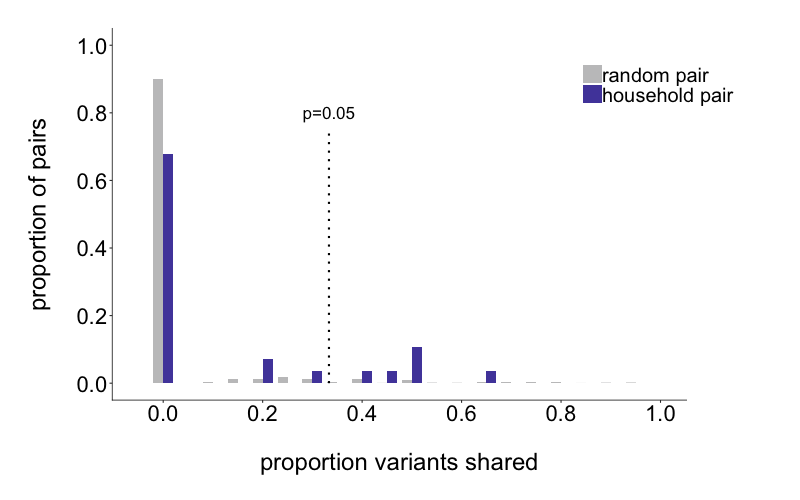

In [44]:
%%R -w 800 -h 500 -u px -i q95,q75,current_date,variant_percent,proportions_combined_df,proportions_df,df2_random,percentile_random_pairs,random_pair_color,household_pair_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("shared-variants-permutation-test-hist-low-freq-",variant_percent,"percent-",current_date,".pdf", sep="")

legend_x = 0.95
legend_y = 0.85
y_end = df2_random$y[[1]]

p <- ggplot() + 
    geom_col(data=proportions_combined_df, aes(x=proportion_shared, y=fraction_pairs, fill=test), position="dodge",width=0.04)+
    geom_segment(aes(x=q95,xend=q95,y=0,yend=0.75),size=1,linetype=3)+
    geom_text(aes(x=q95,y=0.8, label="p=0.05"), size=6)+
    labs(x="\nproportion variants shared",y="proportion of pairs\n")+
    scale_fill_manual(values=c(random_pairs=random_pair_color,trans_pairs=household_pair_color), labels=c("random pair", "household pair"))+
    scale_y_continuous(breaks=seq(0,1,0.2), limits=c(0,1))+
    scale_x_continuous(breaks=seq(0,1,0.2), limits=c(-0.05,1.0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 8, height = 5, device = "pdf", path = "../figures/individual-pdfs/", dpi = 300)
p

In [115]:
df2_random.head()

,pair,sample1,sample2,fraction_shared,y,p_value,color,onset_dates_diff
0,1,USA/WI-UW-41/2020,USA/WI-UW-48/2020,0.000000,8500,1.0000,not,1
1,2,USA/WI-UW-65/2020,USA/WI-UW-32/2020,0.000000,8500,1.0000,not,2
2,3,USA/WI-UW-69/2020,USA/WI-UW-61/2020,0.500000,8500,0.0309,significant,3
3,4,USA/WI-UW-70/2020,USA/WI-UW-67/2020,0.333333,8500,0.0594,not,5
4,5,USA/WI-UW-74/2020,USA/WI-UW-29/2020,0.000000,8500,1.0000,not,4


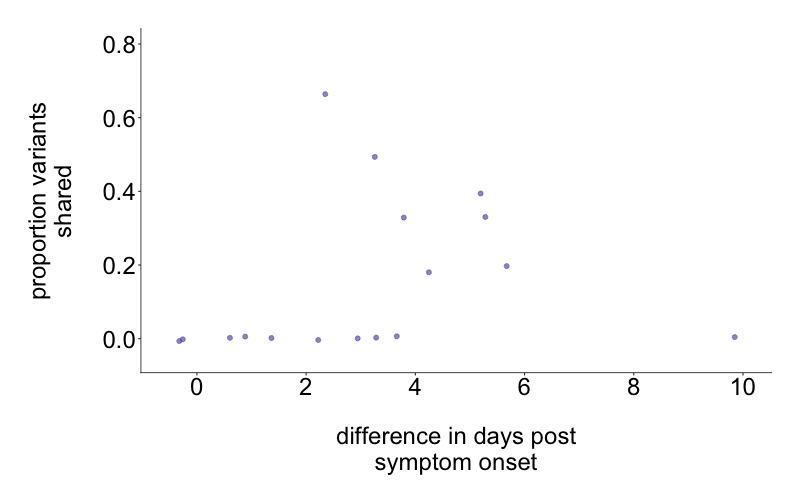

In [79]:
%%R -w 800 -h 500 -u px -i current_date,variant_percent,df2_random,percentile_random_pairs,household_pair_color  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("shared-variants-vs-symptom-onset-",variant_percent,"percent-",current_date,".pdf", sep="")
df2_random$onset_dates_diff = as.numeric(df2_random$onset_dates_diff)

p <- ggplot(data=df2_random, aes(y=fraction_shared, x=onset_dates_diff)) + 
    geom_jitter(size=2, alpha=0.6, color=household_pair_color)+
    #geom_label(data=df2_random, aes(x=fraction_shared,y=y,label=pair),label.size=NA, size=6)+
    labs(x="\ndifference in days post\nsymptom onset",y="proportion variants\nshared\n")+
    #scale_color_manual(values=c(significant="orange",not=not_sig_color), labels=c(" not sig."," p < 0.05"), guide=FALSE)+
    #scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c("tip", "internal node"))+
    scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(-0.05,0.8))+
    scale_x_continuous(limits=c(-0.5,10), breaks=seq(0,10,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=24, colour="black"))+
    theme(axis.text.x=element_text(size=24, colour="black", hjust=0.5))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    #theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 6, height = 5, device = "pdf", path = "../figures/individual-pdfs/", dpi = 300)
p

## Compare to Kat's bottleneck estimates

In [66]:
def read_in_bottleneck_estimates(bottlenecks_file):
    
    return_dict = {}
    with open(bottlenecks_file, "r") as infile: 
        for line in infile:
            if 'tip1' not in line:
                sample1 = line.split("\t")[1]
                sample2 = line.split("\t")[2]
                tube1 = line.split("\t")[6].split(",")[0]
                tube2 = line.split("\t")[6].split(",")[1]
                pair_number = line.split("\t")[12]
                bottleneck_estimate = line.split("\t")[13].strip()
                k = str(sorted([sample1,sample2]))
                return_dict[k] = {"sample1":sample1,"sample2":sample2,"pair_number":pair_number,"tube1":tube1,"tube2":tube2,"bottleneck_size":bottleneck_estimate}
    return(return_dict)

In [67]:
bottlenecks_file = "../data/bottleneck-estimates-2021-02-25.tsv"
trans_pairs_bottlenecks = read_in_bottleneck_estimates(bottlenecks_file)

# tube_to_strain_dict, strain_to_tube_dict = return_tube_sample_dicts(all_intersection_variants)

bottlenecks_df = pd.DataFrame.from_dict(trans_pairs_bottlenecks, orient="index")
bottlenecks_df.reset_index(inplace=True)
bottlenecks_df.head()

,index,sample1,sample2,pair_number,tube1,tube2,bottleneck_size
0,"['USA/WI-UW-158/2020', 'USA/WI-UW-160/2020']",USA/WI-UW-158/2020,USA/WI-UW-160/2020,"pair27, pair27a (195 --> 197), pair27b (197 --...",195,197,1
1,"['USA/WI-UW-29/2020', 'USA/WI-UW-74/2020']",USA/WI-UW-74/2020,USA/WI-UW-29/2020,pair5,61,5,1
2,"['USA/WI-UW-32/2020', 'USA/WI-UW-65/2020']",USA/WI-UW-65/2020,USA/WI-UW-32/2020,"pair2, pair2a (8 --> 50), pair2b (50 --> 8)",50,8,1
3,"['USA/WI-UW-333/2020', 'USA/WI-UW-334/2020']",USA/WI-UW-333/2020,USA/WI-UW-334/2020,"pair28, pair28a (453 --> 454), pair28b (454 --...",453,454,14
4,"['USA/WI-UW-41/2020', 'USA/WI-UW-48/2020']",USA/WI-UW-41/2020,USA/WI-UW-48/2020,pair1,20,28,1


In [68]:
def return_index_column(row):
    s1 = row['sample1']
    s2 = row['sample2']
    index = str(sorted([s1,s2]))
    return(index)

In [69]:
df2_random_with_tube = df2_random.copy()
df2_random_with_tube['index'] = df2_random_with_tube.apply(return_index_column, axis=1)

df2_random_with_tube.head()

,pair,sample1,sample2,fraction_shared,y,p_value,diff_symptom_onset_dates,color,index
0,1,USA/WI-UW-41/2020,USA/WI-UW-48/2020,0.000000,8500,1.0000,5,not,"['USA/WI-UW-41/2020', 'USA/WI-UW-48/2020']"
1,2,USA/WI-UW-65/2020,USA/WI-UW-32/2020,0.000000,8500,1.0000,2,not,"['USA/WI-UW-32/2020', 'USA/WI-UW-65/2020']"
2,3,USA/WI-UW-69/2020,USA/WI-UW-61/2020,0.500000,8500,0.0330,1,significant,"['USA/WI-UW-61/2020', 'USA/WI-UW-69/2020']"
3,4,USA/WI-UW-70/2020,USA/WI-UW-67/2020,0.333333,8500,0.0582,9,not,"['USA/WI-UW-67/2020', 'USA/WI-UW-70/2020']"
4,5,USA/WI-UW-74/2020,USA/WI-UW-29/2020,0.000000,8500,1.0000,4,not,"['USA/WI-UW-29/2020', 'USA/WI-UW-74/2020']"


In [70]:
# merge dataframe
sloth = df2_random_with_tube.merge(bottlenecks_df, on=['index'], how="outer")
#sloth[sloth['color'] == 'significant']
sloth

,pair,sample1_x,sample2_x,fraction_shared,y,p_value,diff_symptom_onset_dates,color,index,sample1_y,sample2_y,pair_number,tube1,tube2,bottleneck_size
0,1,USA/WI-UW-41/2020,USA/WI-UW-48/2020,0.000000,8500,1.0000,5,not,"['USA/WI-UW-41/2020', 'USA/WI-UW-48/2020']",USA/WI-UW-41/2020,USA/WI-UW-48/2020,pair1,20,28,1
1,2,USA/WI-UW-65/2020,USA/WI-UW-32/2020,0.000000,8500,1.0000,2,not,"['USA/WI-UW-32/2020', 'USA/WI-UW-65/2020']",USA/WI-UW-65/2020,USA/WI-UW-32/2020,"pair2, pair2a (8 --> 50), pair2b (50 --> 8)",50,8,1
2,3,USA/WI-UW-69/2020,USA/WI-UW-61/2020,0.500000,8500,0.0330,1,significant,"['USA/WI-UW-61/2020', 'USA/WI-UW-69/2020']",USA/WI-UW-69/2020,USA/WI-UW-61/2020,"pair3, pair3a (55 --> 44), pair3b (44 --> 55)",55,44,1
3,4,USA/WI-UW-70/2020,USA/WI-UW-67/2020,0.333333,8500,0.0582,9,not,"['USA/WI-UW-67/2020', 'USA/WI-UW-70/2020']",USA/WI-UW-70/2020,USA/WI-UW-67/2020,pair4,56,53,1
4,5,USA/WI-UW-74/2020,USA/WI-UW-29/2020,0.000000,8500,1.0000,4,not,"['USA/WI-UW-29/2020', 'USA/WI-UW-74/2020']",USA/WI-UW-74/2020,USA/WI-UW-29/2020,pair5,61,5,1
5,6,USA/WI-UW-119/2020,USA/WI-UW-120/2020,0.000000,8500,1.0000,11,not,"['USA/WI-UW-119/2020', 'USA/WI-UW-120/2020']",NaN,NaN,NaN,NaN,NaN,NaN
6,7,USA/WI-UW-158/2020,USA/WI-UW-160/2020,0.000000,8500,1.0000,,not,"['USA/WI-UW-158/2020', 'USA/WI-UW-160/2020']",USA/WI-UW-158/2020,USA/WI-UW-160/2020,"pair27, pair27a (195 --> 197), pair27b (197 --...",195,197,1
7,8,USA/WI-UW-333/2020,USA/WI-UW-334/2020,0.000000,8500,1.0000,,not,"['USA/WI-UW-333/2020', 'USA/WI-UW-334/2020']",USA/WI-UW-333/2020,USA/WI-UW-334/2020,"pair28, pair28a (453 --> 454), pair28b (454 --...",453,454,14
8,9,USA/WI-UW-438/2020,USA/WI-UW-432/2020,0.666667,8500,0.0208,2,significant,"['USA/WI-UW-432/2020', 'USA/WI-UW-438/2020']",USA/WI-UW-438/2020,USA/WI-UW-432/2020,pair6,744,738,1000
9,10,USA/WI-UW-544/2020,USA/WI-UW-551/2020,0.333333,8500,0.0582,4,not,"['USA/WI-UW-544/2020', 'USA/WI-UW-551/2020']",USA/WI-UW-544/2020,USA/WI-UW-551/2020,pair7,893,884,74


In [71]:
df2_random

,pair,sample1,sample2,fraction_shared,y,p_value,diff_symptom_onset_dates,color
0,1,USA/WI-UW-41/2020,USA/WI-UW-48/2020,0.000000,8500,1.0000,5,not
1,2,USA/WI-UW-65/2020,USA/WI-UW-32/2020,0.000000,8500,1.0000,2,not
2,3,USA/WI-UW-69/2020,USA/WI-UW-61/2020,0.500000,8500,0.0330,1,significant
3,4,USA/WI-UW-70/2020,USA/WI-UW-67/2020,0.333333,8500,0.0582,9,not
4,5,USA/WI-UW-74/2020,USA/WI-UW-29/2020,0.000000,8500,1.0000,4,not
5,6,USA/WI-UW-119/2020,USA/WI-UW-120/2020,0.000000,8500,1.0000,11,not
6,7,USA/WI-UW-158/2020,USA/WI-UW-160/2020,0.000000,8500,1.0000,,not
7,8,USA/WI-UW-333/2020,USA/WI-UW-334/2020,0.000000,8500,1.0000,,not
8,9,USA/WI-UW-438/2020,USA/WI-UW-432/2020,0.666667,8500,0.0208,2,significant
9,10,USA/WI-UW-544/2020,USA/WI-UW-551/2020,0.333333,8500,0.0582,4,not
